In [2]:
import numpy as np
import matplotlib.pyplot as plt
import starry

import exoplanet as exo


In [3]:
starry.__version__

'1.0.0.dev3'

In [4]:
map = starry.Map(ydeg=20, udeg=2, rv=True, lazy=False)


In [5]:
time, vels, verr = np.loadtxt('../data/transit.vels', usecols=[0,1,2], unpack=True)
time -= 2458706.5

In [6]:
Prot = 2.85             # days
P = 8.1387              # days
t0 = 0.168
e = 0.0                   
w = 0.0
inc = 90.0


vsini = 18.3 * 1e3      # m /s
r = 0.06472             # In units of Rstar
b = -0.40               # I want it to transit in the South!
a = 19.42               # In units of Rstar
u1 = 0.95
u2 = 0.20
obl = -0
gamma = -15
gammadot = 100
gammadotdot = 800

veq = vsini / np.sin(inc * np.pi / 180.0)



Compiling `rv`... Done.
/home/bmontet/anaconda3/envs/p35/lib/python3.5/site-packages/theano/tensor/subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


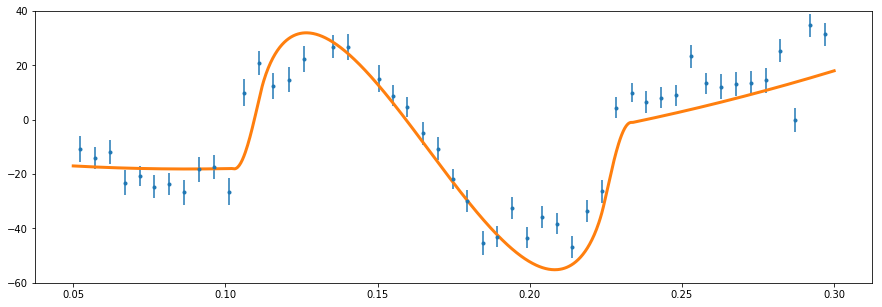

In [7]:
map.reset()
map.inc = inc
map.obl = obl
#map.add_spot(spot_amp, sigma=spot_sig, lon=spot_lon, lat=-spot_lat)
map[1:] = [u1, u2]
map.veq = veq

orbit = exo.orbits.KeplerianOrbit(period=P, a=a, t0=t0, b=b, ecc=e, omega=w, r_star=1.0) 


t = np.linspace(0.05, 0.30, 1000)


f = (t - t0)/P*2*np.pi
I = np.arccos(b/a)

zo = a*np.cos(f) 
yo = -a*np.sin(np.pi/2+f)*np.cos(I)
xo = a*np.sin(f)*np.sin(I)


theta = 360.0 / Prot * t

rv = map.rv(xo=xo, yo=yo, zo=zo, ro=r, theta=theta)
rv += gamma + gammadot*(t-0.15) + gammadotdot*(t-0.15)**2
    

plt.figure(figsize=(15,5))
plt.plot(t, rv, "C1", lw=3)
plt.errorbar(time, vels, yerr=verr, fmt='.')
plt.ylim(-60, 40);

Compiling `render`... Done.


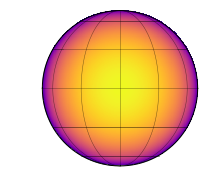

In [8]:
map.show(rv=False)

In [9]:
from scipy.optimize import minimize

In [156]:
tuse = time + 0.0
euse = verr + 0.0
vuse = vels + 0.0


def rmcurve(params):
    
    vsini, r, b, a, u1, u2, obl, gamma, gammadot, gammadotdot, jitter_good, jitter_bad, q, t0 = params
    veq = vsini / np.sin(inc * np.pi / 180.0)

    map.reset()

    map.inc = inc
    map.obl = obl
    #map.add_spot(spot_amp, sigma=spot_sig, lon=spot_lon, lat=-spot_lat)
    map[1:] = [u1, u2]
    map.veq = veq


    f = (tuse - t0)/P*2*np.pi
    I = np.arccos(b/a)

    zo = a*np.cos(f) 
    yo = -a*np.sin(np.pi/2+f)*np.cos(I)
    xo = a*np.sin(f)*np.sin(I)


    theta = 360.0 / Prot * tuse

    rv_0 = map.rv(xo=xo, yo=yo, zo=zo, ro=r, theta=theta)
    rv = rv_0 + 0.0#gamma + gammadot*(tuse-0.15) + gammadotdot*(tuse-0.15)**2
    
    
    var_good = (euse**2 + jitter_good**2)
    var_bad  = (euse**2 + jitter_bad**2)
   
    goodgauss = q / np.sqrt(2*np.pi*var_good) * np.exp(-(rv-vuse)**2/(2*var_good))
    badgauss  = (1-q) / np.sqrt(2*np.pi*var_bad) * np.exp(-(rv_0*0.75-vuse)**2/(2*var_bad))

    totgauss = np.log(goodgauss + badgauss)
    
    print(np.log(goodgauss))
    print(np.log(badgauss))
        
    print(-1*np.sum(totgauss))
    return -1*np.sum(totgauss)



In [151]:
def plot_rmcurve(params):

    vsini, r, b, a, u1, u2, obl, gamma, gammadot, gammadotdot, jitter_good, jitter_bad, q, t0 = params
    veq = vsini / np.sin(inc * np.pi / 180.0)

    map.reset()

    map.inc = inc
    map.obl = obl
    #map.add_spot(spot_amp, sigma=spot_sig, lon=spot_lon, lat=-spot_lat)
    map[1:] = [u1, u2]
    map.veq = veq


    f = (t - t0)/P*2*np.pi
    I = np.arccos(b/a)

    zo = a*np.cos(f) 
    yo = -a*np.sin(np.pi/2+f)*np.cos(I)
    xo = a*np.sin(f)*np.sin(I)

    theta = 360.0 / Prot * t

    rv = map.rv(xo=xo, yo=yo, zo=zo, ro=r, theta=theta)
    rv += gamma + gammadot*(t-0.15) + gammadotdot*(t-0.15)**2

    plt.figure(figsize=(15,5))
    plt.plot(t, rv, "C1", lw=3)
    plt.errorbar(time, vels, yerr=verr, fmt='.')
    plt.ylim(-50, 40);
    plt.show()


[ -5.15285317  -8.0944743   -6.00633181 -14.85260857 -16.22928318
 -17.930088   -18.85157897 -18.90651115 -10.18534822  -9.62896617
 -17.1684992   -5.48024701 -11.96144255 -29.07174664 -30.64455853
 -17.46288533  -9.64378731  -5.55830583  -4.86498865  -5.48263821
  -4.04223976  -4.52150377  -3.72498153  -5.63379616  -6.10693383
 -10.89040194  -5.826489    -3.57652871  -2.54127022  -5.70702266
  -5.36149012  -2.537628    -4.88926692  -3.5200383   -7.05016054
  -6.12127621  -3.84198856  -4.70074652  -4.95721716 -17.48955551
  -7.8375643   -6.07529904  -6.9833942   -6.9873642   -7.63990223
 -19.45879257  -2.66175567 -34.70489639 -28.65870033]
[ -6.53914753  -9.48076866  -7.39262617 -16.23890294 -17.61557755
 -19.31638236 -20.23787334 -20.29280552 -11.57164258 -11.01526053
 -18.36503352  -4.9442614   -6.22087458 -15.59826059 -15.72433076
  -8.49339517  -4.81738161  -4.20387147  -4.46432089  -4.72405315
  -4.3821717   -5.53181582  -5.52477665  -9.23486267 -11.35359024
 -19.04536545 -14.5028

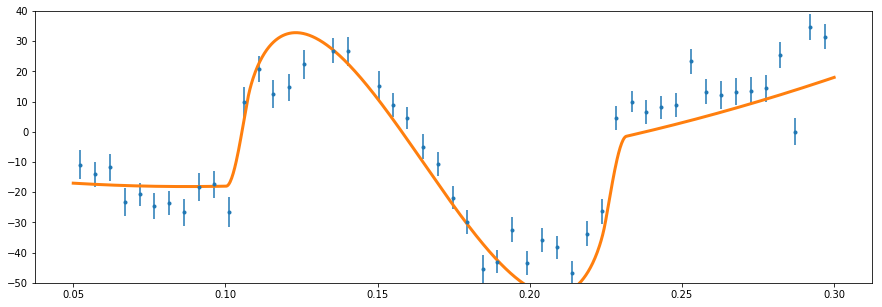

In [158]:
inputs = np.array([19300, 0.0588, -0.09, 20.79, 1.0, 0.00, 10.0, -15.0, 100.1, 800.0, 1.0, 1.0, 0.8, 0.166])

bnds = ((12000, 24000), (0.04, 0.07), (-1.0, 0.0), (15,25), (0,1),(0,1), (-30,90), (-20,20),(50,300), (700, 900), (0.0, 2.0), (0.0, 20.0), (0.7, 1.0), (0.16, 0.175))
rmcurve(inputs)

plot_rmcurve(inputs)

In [153]:
res = minimize(rmcurve, inputs, method='L-BFGS-B', bounds=bnds)

431.8997280489845
431.89972804904113
431.8997660589163
431.8997276677722
431.8997278033597
431.8997273362622
431.89972761144907
431.8997280550152
431.8997280489845
431.8997280489845
431.8997280489845
431.8997278377447
431.8997279765997
431.8997285037547
431.89978256020044
295.6039478820021
295.6039478819842
295.6039321978294
295.60394780035847
295.6039479329586
295.60394799483925
295.6039479649774
295.60394788299914
295.6039478820021
295.6039478820021
295.6039478820021
295.60394786201124
295.6039477102789
295.60394872895625
295.6039461270698
290.01227914005733
290.0122791400463
290.01227272371824
290.012279031976
290.01227917317095
290.0122794477575
290.0122793425367
290.01227914066703
290.01227914005733
290.01227914005733
290.01227914005733
290.01227911651307
290.01227897927964
290.01227995021753
290.01226307281337
295.1500664307042
295.15006643073855
295.1500885188498
295.1500663734979
295.15006646303556
295.15006741977334
295.1500671103831
295.15006642878933
295.1500664307042
295.15

226.18458422202
226.18458423746583
226.1845849128002
226.18458428697832
226.18441718516814
226.18441718516823
226.18441717942704
226.1844171263497
226.1844171995729
226.1844171852356
226.1844172052453
226.18441718516496
226.18441718516814
226.18441718516814
226.18441718516814
226.18441716777562
226.1844171832241
226.18441785859923
226.18441720447785
226.1843998813669
226.184399881367
226.18439988725868
226.18439982258053
226.18439989573685
226.18439988136603
226.1843999013944
226.1843998813629
226.1843998813669
226.1843998813669
226.1843998813669
226.1843998639742
226.18439987942284
226.18440055480042
226.18439988391034
226.18431322398618
226.18431322398632
226.1843132708676
226.18431316531408
226.1843132382259
226.18431322372143
226.18431324382055
226.18431322397933
226.18431322398618
226.18431322398618
226.18431322398618
226.18431320659303
226.18431322204228
226.1843138974293
226.18431316518243
226.18415480563235
226.18415480563255
226.18415489776666
226.18415474708513
226.1841548197

223.62326393334982
223.62326314173035
223.62326312444978
223.62326306649427
223.6232631008268
223.62326312755195
223.6232631275436
223.6232631275436
223.6232631275436
223.62326311171688
223.6232631271711
223.62326379692072
223.62326332303167
224.2955623837291
224.2955623837386
224.2955690116373
224.29556243054054
224.29556238379632
224.29556234108517
224.29556237926445
224.29556238388656
224.2955623837291
224.2955623837291
224.2955623837291
224.2955623657207
224.29556238392345
224.2955630614364
224.29557124294502
223.62182843997826
223.62182843997982
223.62182950328943
223.6218284552529
223.62182843700091
223.62182837925653
223.62182841390748
223.62182843998968
223.62182843997826
223.62182843997826
223.62182843997826
223.62182842412037
223.62182843962756
223.62182910948727
223.6218290837845
223.45111774926698
223.45111774926934
223.45111938318806
223.45111776886736
223.45111774625505
223.45111769590235
223.45111772838152
223.45111774928895
223.45111774926698
223.45111774926698
223.4511

221.27819847598622
221.2781984258704
221.27819842491675
221.27819842491675
221.27819842491675
221.27819841003426
221.27819842491087
221.27819906343535
221.2781985356812
269.49561802356413
269.4956180235657
269.4956193525405
269.49561880082916
269.4956180232514
269.49561809475455
269.49561807666055
269.4956180227655
269.49561802356413
269.49561802356413
269.49561802356413
269.49561800030835
269.49561800943064
269.49561918358114
269.49561972744186
221.19734093807324
221.19734093807313
221.1973406020092
221.19734090617698
221.19734095080833
221.1973409814099
221.19734099382634
221.19734093903395
221.19734093807324
221.19734093807324
221.19734093807324
221.19734092309574
221.19734093810368
221.19734157522484
221.1973420106678
272.8376216658326
272.83762166583756
272.8376243641787
272.83762329289436
272.83762166175484
272.8376219023159
272.8376218372832
272.83762166346014
272.8376216658326
272.8376216658326
272.8376216658326
272.8376216443238
272.8376216481667
272.8376228266072
272.83762441

213.32222853141494
213.32222855240616
213.32222904892114
213.3222286447476
213.3206820692697
213.32068206926948
213.32068204932722
213.32068201261424
213.32068207166753
213.3206819354757
213.32068198153408
213.32068206779434
213.3206820692697
213.3206820692697
213.3206820692697
213.3206820494936
213.32068207055707
213.3206825664359
213.32068220164405
213.31749804889526
213.31749804889503
213.3174980106333
213.3174979877962
213.31749805123897
213.3174979142901
213.31749796042362
213.3174980473021
213.31749804889526
213.31749804889526
213.31749804889526
213.31749802904264
213.31749805018217
213.31749854543446
213.31749814629325
213.2994101381982
213.29941013819797
213.2994101247947
213.2994100617625
213.29941014071645
213.29941000210025
213.29941004830349
213.29941013622772
213.2994101381982
213.2994101381982
213.2994101381982
213.29941011812673
213.29941013948755
213.29941063281768
213.29940999932563
213.2531072480039
213.25310724800383
213.25310737500186
213.25310714159556
213.25310725

210.04116358206585
210.04116250873315
210.04116354521662
210.04116358628556
210.0411635636652
210.0411635793732
210.0411635822057
210.04116358206787
210.04116358206787
210.04116358206787
210.0411635667044
210.04116358337578
210.04116404833923
210.0411623072749
210.02060093437467
210.0206009343729
210.02060017709408
210.0206008853271
210.02060094350384
210.02060092348046
210.02060093648436
210.02060093461915
210.02060093437467
210.02060093437467
210.02060093437467
210.02060091928394
210.02060093557657
210.02060140308015
210.0205985050299
210.04931288106042
210.04931288106
210.04931294909713
210.0493129243392
210.0493128794129
210.04931284779505
210.04931287035524
210.04931288151903
210.04931288106042
210.04931288106042
210.04931288106042
210.04931286637577
210.0493128822059
210.0493133546657
210.04931869346908
210.01336441536378
210.01336441536242
210.0133639123305
210.01336439594232
210.01336442102152
210.01336439713359
210.01336441320657
210.01336441566926
210.01336441536378
210.01336

209.97398868065233
209.9739886806242
209.9739886806242
209.9739886806242
209.97398866545967
209.97398868150114
209.97398915178061
209.97398865002333
209.97399183538283
209.9739918353821
209.97399182233715
209.9739918348268
209.97399183553247
209.9739918172426
209.9739918348214
209.97399183540963
209.97399183538283
209.97399183538283
209.97399183538283
209.97399182022087
209.97399183625726
209.9739923065649
209.9739917949518
209.97398861369473
209.973988613694
209.97398860747782
209.9739886136845
209.9739886137235
209.9739885954648
209.97398861308736
209.97398861372244
209.97398861369473
209.97398861369473
209.97398861369473
209.97398859853098
209.9739886145709
209.97398908485883
209.97398858016157


In [154]:
# vsini, r, b, a, u1, u2, obl, gamma, gammadot, gammadotdot, jitter_good, jitter_bad, q, t0
print(res.x.tolist())

[18115.442213492246, 0.05284604341635971, -0.2066770851086312, 19.125250769047977, 1.0, 0.8174820325729144, -23.312283014905436, -15.0, 100.1, 800.0, 2.0, 19.372011784855903, 0.7, 0.16627194612214563]


[ -5.07942723  -7.52353088  -5.78541163 -13.59422146 -14.23799033
 -16.11711614 -16.63218451 -17.15585125  -9.49204579  -8.98651415
 -25.63437095  -5.71469243  -3.74122956  -8.15923991  -6.90101403
  -3.41436877  -3.34389798  -4.17770494  -3.46118936  -3.10422628
  -3.20315637  -2.81829663  -2.82075748  -4.21505254  -5.87162379
 -12.4827034   -9.02481912  -2.82079863  -5.00838565  -2.77391127
  -2.75645321  -4.99098951  -2.90002008  -3.49679249 -21.61149671
  -8.86479933  -3.8554625   -4.55774548  -4.80786911 -15.59357913
  -7.25415134  -5.86283708  -6.626889    -6.65086298  -7.21775907
 -17.3927072   -2.86237694 -30.48015711 -25.32408516]
[-5.26429174 -5.36346606 -5.28867077 -5.79130427 -5.65428631 -5.87779204
 -5.818695   -6.01347849 -5.53471832 -5.49591152 -6.53694569 -5.17906516
 -5.11215372 -5.22325555 -5.17534487 -5.1214814  -5.24570664 -5.32368405
 -5.1952338  -5.13802807 -5.12762287 -5.11279811 -5.12401932 -5.26072278
 -5.42198797 -6.08081724 -5.74726529 -5.21328    -5.51337938

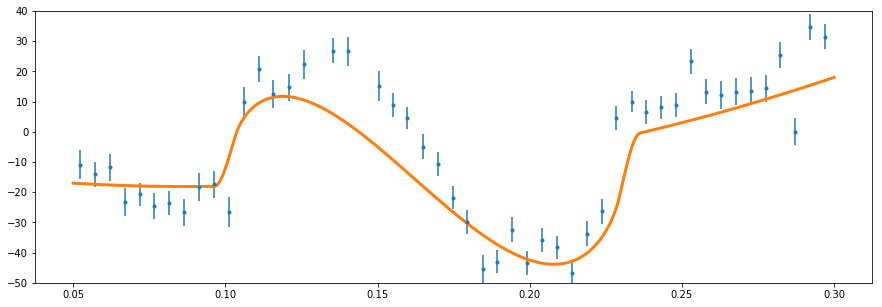

In [157]:
test = res.x + 0.0
#test[0] = 20000
test[4] = 1.0
test[5] = 0.0
rmcurve(test)
plot_rmcurve(test)

In [81]:
orbit = exo.orbits.KeplerianOrbit(period=P, a=a, t0=t0, b=0.4, ecc=e, omega=w, r_star=1.0) 

x, y, z = orbit.get_relative_position(tuse)


In [82]:
xp = x.eval()
yp = y.eval()
zp = z.eval()

In [83]:
(zp**2+yp**2+xp**2)**0.5

array([19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42,
       19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42,
       19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42,
       19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42,
       19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42,
       19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42,
       19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42,
       19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42,
       19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42, 19.42])

In [84]:
a

19.42

In [85]:
tuse = np.arange(-4, 4, 0.1)

f = (tuse - t0)/P*2*np.pi
I = np.arccos(b/a)


In [106]:


zpos = a*np.cos(f) 
ypos = -a*np.sin(np.pi/2+f)*np.cos(I)
xpos = a*np.sin(f)*np.sin(I)

In [108]:
zpos-zp

array([-4.10861147e-03, -4.11988110e-03, -4.10660824e-03, -4.06887196e-03,
       -4.00689705e-03, -3.92105270e-03, -3.81185031e-03, -3.67994039e-03,
       -3.52610875e-03, -3.35127177e-03, -3.15647097e-03, -2.94286680e-03,
       -2.71173171e-03, -2.46444261e-03, -2.20247260e-03, -1.92738228e-03,
       -1.64081037e-03, -1.34446401e-03, -1.04010856e-03, -7.29557091e-04,
       -4.14659590e-04, -9.72919255e-05,  2.20655316e-04,  5.37288094e-04,
        8.50720200e-04,  1.15908449e-03,  1.46054402e-03,  1.75330295e-03,
        2.03561731e-03,  2.30580532e-03,  2.56225745e-03,  2.80344598e-03,
        3.02793415e-03,  3.23438464e-03,  3.42156763e-03,  3.58836804e-03,
        3.73379223e-03,  3.85697389e-03,  3.95717923e-03,  4.03381130e-03,
        4.08641361e-03,  4.11467280e-03,  4.11842052e-03,  4.09763446e-03,
        4.05243843e-03,  3.98310167e-03,  3.89003722e-03,  3.77379949e-03,
        3.63508091e-03,  3.47470783e-03,  3.29363561e-03,  3.09294292e-03,
        2.87382531e-03,  

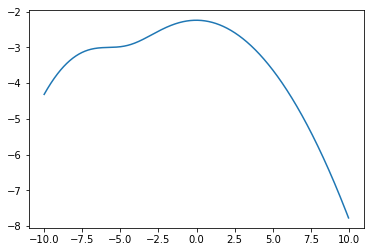

In [50]:
x = np.arange(-10, 10, 0.02)
sigma1 = 3
mu1 = 0

sigma2 = 2
mu2 = -7
g1 = 0.8/np.sqrt(2*np.pi*sigma1**2) * np.exp(-(x-mu1)**2/(2*sigma1**2))
g2 = 0.2/np.sqrt(2*np.pi*sigma2**2) * np.exp(-(x-mu2)**2/(2*sigma2**2))

plt.plot(x, np.log(g1+g2))
#plt.plot(x, g1)
#plt.plot(x, g2)


In [ ]:
var_good = (euse**2 + jitter_good**2)
var_bad  = (euse**2 + jitter_bad**2)
gooddata = -0.5*q*(np.sum((rv-vuse)**2/var_good + np.log(2*np.pi*var_good)))
baddata  = -0.5*(1-q)*(np.sum((rv-vuse)**2/var_bad + np.log(2*np.pi*var_bad)))
lnprob = gooddata + baddata
    
goodgauss = q / np.sqrt(2*np.pi*var_good) * np.exp(-(rv-vuse)**2/var_good)
badgauss  = (1-q) / np.sqrt(2*np.pi*var_bad) * np.exp(-(rv-vuse)**2/var_bad)

totgauss = np.log(goodgauss + badgauss)

